In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt

tf.__version__ 

'2.4.1'

In [15]:
Ne = 128  # Number of transducer elements
Nx, Nz = 387, 609
pixels = Nx * Nz

# 1. Reproduce ABLE

## 1-1. Build and compile a model

In [3]:
def antirectifier(x):   #copy from https://www.tensorflow.org/.../keras/layers/Lambda
    x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    pos = K.relu(x)
    neg = K.relu(-x)
    return K.concatenate([pos, neg], axis=1)

In [4]:
_input = keras.Input(shape=(Ne,))
x = keras.layers.Dense(Ne)(_input)
x = keras.layers.Lambda(antirectifier)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(Ne/4)(x)
x = keras.layers.Lambda(antirectifier)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(Ne/4)(x)
x = keras.layers.Lambda(antirectifier)(x)
x = keras.layers.Dropout(0.2)(x)

weights = keras.layers.Dense(Ne, name = "weights")(x)  # no activation is applied

In [5]:
multiplied = keras.layers.Multiply()([_input, weights])

In [6]:
output = keras.layers.Lambda(lambda x: K.sum(x, axis=1, keepdims=True), name="output")(multiplied)

In [7]:
model = keras.Model(
    inputs=[_input],
    outputs=[output],
)

In [22]:
#keras.utils.plot_model(model, "ABLE_model_with_shape_info.png", show_shapes=True)

In [ ]:
# def signed_mean_squared_logarithmic_error(y_true, y_pred, scale=1.):
#     first_log = K.log(K.clip(K.abs(y_pred[:, :1]) * scale, K.epsilon(), None) + 1.) * K.sign(y_pred[:, :1])
#     second_log = K.log(K.clip(K.abs(y_true[:, :1]) * scale, K.epsilon(), None) + 1.) * K.sign(y_true[:, :1])
#     return K.mean(K.square(first_log - second_log), axis=-1)

In [ ]:
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#     loss={
#         "output": keras.losses.MeanSquaredLogarithmicError()
#     },
#     loss_weights={"output":1.0},
# )

In [8]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    loss = keras.losses.MeanSquaredLogarithmicError(),
    metrics = [keras.metrics.MeanSquaredLogarithmicError()]
) 


## 1-2. Prepare x_train and y_train

In [9]:
inputFilepath = r'E:\Desktop\internshipDeepUS\04_14_2021\Input_Target_ABLE\input\PICMUS16.mat'
targetFilepath = r'E:\Desktop\internshipDeepUS\04_14_2021\Input_Target_ABLE\target\PICMUS16.mat'
datasetsNames = ['carotid_cross','carotid_long','contrast_expe','resolution_expe','contrast_simu','resolution_simu']

In [10]:
inputFile = scio.loadmat(inputFilepath)
targetFile = scio.loadmat(targetFilepath)

In [11]:
print("input shape:",inputFile[datasetsNames[1]].shape)
print("target shape:",targetFile[datasetsNames[1]].shape)

input shape: (235683, 128)
target shape: (235683, 1)


In [12]:
x_train = np.concatenate([inputFile[datasetsNames[i]] for i in range(len(datasetsNames))],axis=0) # x_train.shape=(1414098, 128)
y_train = np.concatenate([targetFile[datasetsNames[i]] for i in range(len(datasetsNames))],axis=0)# y_train.shape=(1414098, 1)

## 1-3. Train and save the model

In [13]:
model.fit(
    x=x_train, y=y_train, batch_size=None, epochs=3, verbose=1
)

Epoch 1/3
44191/44191 [==============================] - 254s 5ms/step - loss: 1.3453 - mean_squared_logarithmic_error: 1.3453
Epoch 2/3
44191/44191 [==============================] - 207s 5ms/step - loss: 0.6916 - mean_squared_logarithmic_error: 0.6916
Epoch 3/3
44191/44191 [==============================] - 221s 5ms/step - loss: 0.5382 - mean_squared_logarithmic_error: 0.5382


In [14]:
model.save('my_model.tf')
model.save_weights("my_weights.tf")

INFO:tensorflow:Assets written to: my_model.tf\assets


# 2. Just for testing

## 2-1. Predict with the training datasets, and save predicted results

In [ ]:
# from keras.models import load_model
# model = load_model('my_model.h5')
# keras.model.load_weights(filepath)

In [29]:
y_predict = np.zeros((pixels,len(datasetsNames)))

for i in range(len(datasetsNames)):
    y_predict[:,i] = np.squeeze(model.predict(x = inputFile[datasetsNames[i]]))
    
scio.savemat("PICMUS16_predicted.mat", {datasetsNames[i]: y_predict[:,i] for i in range(len(datasetsNames))})

## 2-2. Show one predicted image in the simplist way

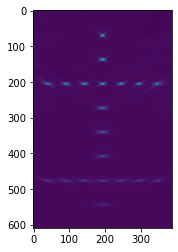

In [48]:
y_predict_max = y_predict[:,5].max()
y_predict_log = 20.*np.log10((1./y_predict_max)*y_predict[:,5]+1)

y_img_data = np.reshape(y_predict_log, (Nz,Nx))

plt.imshow(y_img_data)
#plt.savefig(filename)